In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from omegaconf import OmegaConf
from models.flow_module import FlowModule
import torch
from data.pdb_dataloader import PdbDataModule
import glob
import GPUtil
from data import utils as du
import numpy as np
import tree
from data import so3_utils
from data import all_atom
from analysis import utils as au
from openfold.utils.superimposition import superimpose
import matplotlib.pyplot as plt
import pandas as pd
import plotnine as gg
from tmtools import tm_align
import mdtraj as md

In [3]:
def extract_ca(path):
    pdb_feats = du.parse_pdb_feats('a', path)
    return pdb_feats['bb_positions']

In [4]:
genie_samples_dir = '/Mounts/rbg-storage1/users/jyim/genie_results/eval_results/eval_results/ts_500'
designs_dir = os.path.join(genie_samples_dir, 'pdbs/*')
structures_dir = os.path.join(genie_samples_dir, 'structures')

In [5]:
designs_to_score = {
    'sample_id': [],
    'length': [],
    'max_tm_score': []
}
all_samples = glob.glob(designs_dir)

for i,design_path in enumerate(all_samples):
    design_fname = os.path.basename(design_path).replace('.pdb', '')
    length, sample_id = [int(x) for x in design_fname.split('_')]
    design_pdb = extract_ca(design_path)
    max_tm = 0
    if i % 50 == 0:
        print(f'On {i}/{len(all_samples)}')
    for i in range(8):
        resample_path = os.path.join(structures_dir, f'{design_fname}-resample_{i}.pdb')
        resample_pdb = extract_ca(resample_path)
        num_res = resample_pdb.shape[0]
        seq = 'A'*num_res
        tm_results = tm_align(design_pdb, resample_pdb, seq, seq)
        tm_score = tm_results.tm_norm_chain1
        if tm_score > max_tm:
            max_tm = tm_score
    designs_to_score['sample_id'].append(sample_id)
    designs_to_score['length'].append(length)
    designs_to_score['max_tm_score'].append(max_tm)
results_df = pd.DataFrame(designs_to_score)
designability = (results_df.max_tm_score > 0.5).mean()
print(f'Designability: {designability}')

On 0/790
On 50/790
On 100/790
On 150/790
On 200/790
On 250/790
On 300/790
On 350/790
On 400/790
On 450/790
On 500/790
On 550/790
On 600/790
On 650/790
On 700/790
On 750/790
Designability: 0.0


<Axes: >

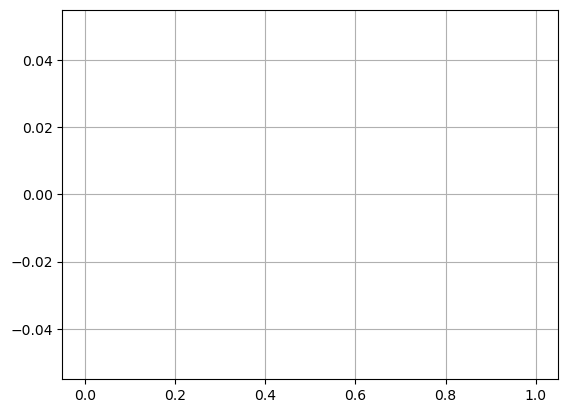

In [6]:
results_df.max_tm_score.hist()

In [53]:
Designability: 0.8544303797468354

0.0

In [ ]:
base_path = '../configs/base.yaml'

cfg = OmegaConf.load(base_path)
cfg.experiment.checkpointer.dirpath = './'
cfg.data.dataset.csv_path = '../preprocessed/metadata.csv'

flow = FlowModule(
    model_cfg=cfg.model,
    experiment_cfg=cfg.experiment
)

_ = flow.eval()

In [ ]:
# Set up data module
data_module = PdbDataModule(cfg.data)
data_module.setup('fit')
train_dataloader = data_module.train_dataloader(
    num_replicas=1,
    rank=1
)
data_iter = iter(train_dataloader)


In [ ]:
# Search for a reasonable batch
stop_search = False
while not stop_search: 
    batch = next(data_iter)
    num_batch, num_res, _ = batch['trans_1'].shape
    if num_res > 100:
        stop_search = True
print(f'Found batch with {num_res} residues, {num_batch} batch size')

# Set up device and cuda
num_batch, num_res, _ = batch['trans_1'].shape
cuda_id = GPUtil.getAvailable(order='memory', limit = 8)[0]
device = 'cpu'
print(f'Using device {device}')
flow.model = flow.model.to(device)
batch = tree.map_structure(lambda x: x.to(device), batch)

In [ ]:
# Take lots of samples
num_samples = 100
all_noisy_batches = [flow._corrupt_batch(batch) for _ in range(num_samples)]

all_t = du.to_numpy(torch.stack([x['t'] for x in all_noisy_batches]).reshape(-1))
t_factor = 1/(1 - all_t[..., None, None])

all_rotmats_t = torch.stack([x['rotmats_t'] for x in all_noisy_batches]).reshape(-1, num_res, 3, 3)
all_rotmats_1 = torch.stack([x['rotmats_1'] for x in all_noisy_batches]).reshape(-1, num_res, 3, 3)
gt_rot_vf = so3_utils.calc_rot_vf(
    all_rotmats_t.type(torch.float32),
    all_rotmats_1.type(torch.float32)
) * t_factor

all_trans_t = torch.stack([x['trans_t'] for x in all_noisy_batches]).reshape(-1, num_res, 3)
all_trans_1 = torch.stack([x['trans_1'] for x in all_noisy_batches]).reshape(-1, num_res, 3)
gt_trans_vf = (all_trans_1 - all_trans_t) * 0.1 * t_factor

In [ ]:
rot_vf_magnitudes = np.mean(np.linalg.norm(du.to_numpy(gt_rot_vf), axis=-1), axis=-1)
trans_vf_magnitudes = np.mean(np.linalg.norm(du.to_numpy(gt_trans_vf), axis=-1), axis=-1)

In [ ]:
plt.figure(figsize=(12, 5))
plt.scatter(all_t, rot_vf_magnitudes, label='Rotation')
plt.scatter(all_t, trans_vf_magnitudes, label='Translations')
plt.legend()
plt.grid()
plt.xlabel('t')
plt.ylabel(r'$||x||_2^2$')
plt.title('Normalized loss magnitude')

In [ ]:
rot_vf_magnitudes

In [ ]:
all_noisy_batches = []
for _ in range(10):
    all_noisy_batches.append(flow._corrupt_batch(batch))
all_noisy_batches_2 = [flow._corrupt_batch(batch) for _ in range(10)]

In [ ]:
all_ts = [x['t'] for x in all_noisy_batches]
all_ts_2 = [x['t'] for x in all_noisy_batches_2]

In [ ]:
all_ts[3][:5]

In [ ]:
all_ts_2[0][:5]

In [ ]:
t_sample = torch.stack([x['t'] for x in all_noisy_batches])

In [ ]:
rmsd_df = pd.DataFrame({
    't': all_t,
    'Rotation VF': rot_vf_magnitudes,
    'Translation VF': trans_vf_magnitudes
})

In [ ]:
p = gg.ggplot(gg.aes(x='t', y='Rotation VF'), rmsd_df)
p + gg.geom_point()

In [ ]:
trans_vf_magnitudes.shape

In [ ]:
plt.figure(figsize=(12, 5))
plt.scatter(all_t[:1000], rot_vf_magnitudes[:1000])
plt.scatter(all_t[:1000], trans_vf_magnitudes[:1000])

In [ ]:
plt.hist(all_t)
plt.show()

In [ ]:
# Take lots of samples
num_samples = 1000
all_noisy_batches = [flow._corrupt_batch(batch) for _ in range(num_samples)]

all_t = du.to_numpy(torch.stack([x['t'] for x in all_noisy_batches]).reshape(-1))
all_rotmats_t = torch.stack([x['rotmats_t'] for x in all_noisy_batches]).reshape(-1, num_res, 3, 3)
all_trans_t = torch.stack([x['trans_t'] for x in all_noisy_batches]).reshape(-1, num_res, 3)
all_rotvecs_t = so3_utils.rotmat_to_rotvec(all_rotmats_t)
all_gt_rotvec = gt_rotvec[None].repeat(num_samples, 1, 1, 1).reshape(-1, num_res, 3)
all_gt_trans = gt_trans_1[None].repeat(num_samples, 1, 1, 1).reshape(-1, num_res, 3)

In [ ]:
gt_rot_vf = so3_utils.calc_rot_vf(
    noisy_batch['rotmats_t'].type(torch.float32),
    gt_rotmats_1.type(torch.float32)
)

In [ ]:
rot_dist_t = du.to_numpy(torch.mean(torch.linalg.norm(all_rotvecs_t - all_gt_rotvec, dim=-1), dim=-1))
trans_dist_t = du.to_numpy(torch.mean(torch.linalg.norm(all_trans_t - all_gt_trans, dim=-1), dim=-1))

In [ ]:
plt.scatter(all_t, trans_dist_t)
plt.xlabel('t')
plt.ylabel('RMSD')
plt.title(r'RMSD of $x_t$ and $x_1$')

In [ ]:
plt.scatter(all_t, rot_dist_t)
plt.xlabel('t')
plt.ylabel('RMSD')
plt.title(r'RMSD of $r_t$ and $r_1$')

In [ ]:
plt.hist(all_t)

In [ ]:
all_gt_rot_vf = []
for noisy_batch in all_noisy_batches:
    gt_rot_vf = so3_utils.calc_rot_vf(
        noisy_batch['rotmats_t'].type(torch.float32),
        gt_rotmats_1.type(torch.float32)
    )
    all_gt_rot_vf.append(gt_rot_vf)

In [ ]:
all_rot_vf_mag = du.to_numpy(torch.concat([torch.linalg.norm(x, dim=-1) for x in all_gt_rot_vf]).reshape(-1, num_res))

In [ ]:
plt.scatter(all_t, np.mean(all_rot_vf_mag, axis=-1))
plt.xlabel('t')
plt.ylabel('RMSD')
plt.title('Magnitude of rotation vector field')

In [ ]:
all_rot_vf_mag.max()

# Model prediction at different timesteps

In [ ]:
gt_ca_pos = batch['trans_1']
device = gt_ca_pos.device
num_batch = gt_ca_pos.shape[0]
ts = np.linspace(1e-3, 1.0, num_timesteps)
all_pred_ca = []
all_pred_transrot = []
all_gt_atom37 = []
for i,t in enumerate(ts):
    if i % 100 == 0:
        print(f'On t={t:.2f}')
    batch_t = torch.ones(num_batch, 1, 1, device=device) * t
    noisy_batch = flow._corrupt_batch(batch, t=batch_t)
    noisy_batch['t']
    with torch.no_grad():
        model_out = flow.forward(noisy_batch)
    all_pred_transrot.append((model_out['pred_trans'], model_out['pred_rotmats']))
    all_pred_ca.append(du.to_numpy(model_out['pred_trans']))

    gt_trans_t = noisy_batch['trans_t']
    gt_rotmats_t = noisy_batch['rotmats_t']

    noisy_gt_atom37 = atom37_from_trans_rot(
        gt_trans_t.detach().cpu(),
        gt_rotmats_t.detach().cpu(),
        noisy_batch['res_mask'].detach().cpu()
    )
    noisy_gt_atom37 = du.to_numpy(noisy_gt_atom37)
    all_gt_atom37.append(noisy_gt_atom37)



In [ ]:
# Save samples

all_pred_ca = np.stack(all_pred_ca)
all_pred_atom37 = np.stack(all_atom.transrot_to_atom37(
    all_pred_transrot,
    noisy_batch['res_mask']
))

os.makedirs(save_dir, exist_ok=True)
num_timesteps, num_batch, num_res, _, _ = all_pred_atom37.shape

for i in list(np.linspace(0, num_timesteps-1, 10).astype(int)):
    t = ts[i]
    atom37_t = all_pred_atom37[i]
    _ = au.write_prot_to_pdb(
        atom37_t,
        os.path.join(
            save_dir,
            f'model_out_len_{num_res}_t_{t:.2f}.pdb'),
        no_indexing=True
    )
    _ = au.write_prot_to_pdb(
        all_gt_atom37[i],
        os.path.join(
            save_dir,
            f'gt_len_{num_res}_t_{t:.2f}.pdb'),
        no_indexing=True)
    
    print(f'Done with sample {i}, t={t:.2f}')

In [ ]:
res_mask = batch['res_mask']
aligned_sample_ca, aligned_rmsd = superimpose(
    torch.tensor(gt_ca_pos)[None].repeat(num_timesteps, 1, 1, 1),
    torch.tensor(all_pred_ca).to(gt_ca_pos.device),
    res_mask[None].repeat(num_timesteps, 1, 1)
)
# torch.mean(aligned_rmsd)
ts_rmsd = du.to_numpy(torch.mean(aligned_rmsd, dim=-1))

plt.plot(ts, ts_rmsd)
plt.xlabel('t')
plt.ylabel('RMSD to ground truth')
# plt.plot(ts, noisy_rmsds)

In [ ]:
np_rmsd = du.to_numpy(aligned_rmsd)
for i in range(np_rmsd.shape[1]):
    plt.plot(ts, np_rmsd[:, i])
plt.xlabel('t')
plt.ylabel('RMSD')
plt.suptitle('RMSD between model\'s x_0 output and ground truth')

# Full sampling

In [ ]:
min_t = 1e-3
t = torch.ones(num_batch, 1, 1, device=device) * min_t
res_mask = batch['res_mask']
noisy_batch = flow._corrupt_batch(batch, t=t)
noisy_batch['t'] = t
do_sde = False
debug_trans = False
debug_rots = True

gt_trans_1 = batch['trans_1']
gt_rotmats_1 = batch['rotmats_1']

gt_atom37 = atom37_from_trans_rot(
    gt_trans_1.detach().cpu(),
    gt_rotmats_1.detach().cpu(),
    res_mask.detach().cpu()
)
gt_atom37 = du.to_numpy(gt_atom37)

In [ ]:
atom37_traj, model_traj = flow.run_sampling(
    (noisy_batch, None),
    return_traj=True,
    return_model_outputs=True,
    num_timesteps=num_timesteps,
    do_sde=do_sde,
    debug_trans=debug_trans,
    debug_rots=debug_rots,
)
atom37_traj = np.stack(atom37_traj).swapaxes(0, 1)
model_traj = np.stack(model_traj).swapaxes(0, 1)

In [ ]:
# Save samples
os.makedirs(save_dir, exist_ok=True)
num_batch, num_timesteps, num_res, _, _ = atom37_traj.shape
max_save = 5
de_form = 'sde' if do_sde else 'ode'
for i, sample_traj in enumerate(atom37_traj):
    if i >= max_save:
        break
    traj_path = au.write_prot_to_pdb(
        sample_traj,
        os.path.join(
            save_dir,
            f'traj_{i}_len_{num_res}_ts_{num_timesteps}_{de_form}.pdb'),
        no_indexing=True
    )
    sample_path = au.write_prot_to_pdb(
        sample_traj[-1],
        os.path.join(
            save_dir,
            f'sample_{i}_len_{num_res}_ts_{num_timesteps}_{de_form}.pdb'),
        no_indexing=True
    )
    _ = au.write_prot_to_pdb(
        model_traj[-1, i],
        os.path.join(
            save_dir,
            f'final_model_out_{i}_len_{num_res}_ts_{num_timesteps}_{de_form}.pdb'),
        no_indexing=True
    )
    _ = au.write_prot_to_pdb(
        model_traj[:, i],
        os.path.join(
            save_dir,
            f'pred_traj_{i}_len_{num_res}_ts_{num_timesteps}_{de_form}.pdb'),
        no_indexing=True
    )  
    _ = au.write_prot_to_pdb(
        gt_atom37[i],
        os.path.join(
            save_dir,
            f'gt_{i}_len_{num_res}_ts_{num_timesteps}.pdb',
        ),
        no_indexing=True
    )
    print(f'Done with sample {i}')
final_samples = atom37_traj[:, -1]
_ = au.write_prot_to_pdb(
    final_samples,
    os.path.join(
        save_dir,
        'all_samples.pdb'),
    no_indexing=True
)


## Manual sampling

In [ ]:
# Run sampling
trans_traj = [noisy_batch['trans_t']]
rots_traj = [noisy_batch['rotmats_t']]
ts = np.linspace(min_t, 1.0, num_timesteps)
t_1 = ts[0]
all_pred_transrot = []
trans_vf_traj = []
for i,t_2 in enumerate(ts[1:]):
    if (i+1) % 100 == 0:
        print(f"Step {i+1} / {len(ts)}")
    d_t = t_2 - t_1
    trans_t_1 = trans_traj[-1]
    rots_t_1 = rots_traj[-1]
    with torch.no_grad():
        noisy_batch['trans_t'] = trans_t_1
        noisy_batch['rotmats_t'] = rots_t_1
        noisy_batch['t'] = torch.ones((num_batch, 1)).to(device) * t_1
        model_out = flow.forward(noisy_batch)

    pred_trans_1 = model_out['pred_trans']
    # pred_trans_1 = batch['trans_1']
    pred_rots_1 = model_out['pred_rotmats']
    # pred_rots_1 = batch['rotmats_1']
    pred_rots_vf = model_out['pred_rots_vf']
    all_pred_transrot.append((pred_trans_1, pred_rots_1))

    trans_vf = (pred_trans_1 - trans_t_1) / (1 - t_1)
    trans_t_2 = trans_t_1 + trans_vf * d_t
    rots_t_2 = so3_utils.geodesic_t(
        d_t / (1 - t_1), pred_rots_1, rots_t_1, rot_vf=pred_rots_vf)
    t_1 = t_2
    trans_traj.append(trans_t_2)
    rots_traj.append(rots_t_2)

res_mask = noisy_batch['res_mask']
all_pred_atom37 = np.stack(all_atom.transrot_to_atom37(
    all_pred_transrot,
    res_mask
))
atom37_traj = process_trans_rot_traj(trans_traj, rots_traj, res_mask)
final_ca_pos = atom37_traj[:, -1, :, 1]
gt_ca_pos = noisy_batch['trans_1']
atom37_traj = du.to_numpy(atom37_traj)

gt_trans_1 = batch['trans_1']
gt_rotmats_1 = batch['rotmats_1']

gt_atom37 = atom37_from_trans_rot(
    gt_trans_1.detach().cpu(),
    gt_rotmats_1.detach().cpu(),
    res_mask.detach().cpu()
)
gt_atom37 = du.to_numpy(gt_atom37)


In [ ]:
# Save samples
os.makedirs(save_dir, exist_ok=True)
num_batch, num_timesteps, num_res, _, _ = atom37_traj.shape
max_save = 5
for i, sample_traj in enumerate(atom37_traj):
    if i >= max_save:
        break
    traj_path = au.write_prot_to_pdb(
        sample_traj,
        os.path.join(
            save_dir,
            f'traj_{i}_len_{num_res}_ts_{num_timesteps}.pdb'),
        no_indexing=True
    )
    sample_path = au.write_prot_to_pdb(
        sample_traj[-1],
        os.path.join(
            save_dir,
            f'sample_{i}_len_{num_res}_ts_{num_timesteps}.pdb'),
        no_indexing=True
    )
    _ = au.write_prot_to_pdb(
        all_pred_atom37[-1, i],
        os.path.join(
            save_dir,
            f'final_model_out_{i}_len_{num_res}_ts_{num_timesteps}.pdb'),
        no_indexing=True
    )
    _ = au.write_prot_to_pdb(
        all_pred_atom37[:, i],
        os.path.join(
            save_dir,
            f'pred_traj_{i}_len_{num_res}_ts_{num_timesteps}.pdb'),
        no_indexing=True
    )  
    _ = au.write_prot_to_pdb(
        gt_atom37[i],
        os.path.join(
            save_dir,
            f'gt_{i}_len_{num_res}_ts_{num_timesteps}.pdb',
        ),
        no_indexing=True
    )
    print(f'Done with sample {i}')
final_samples = atom37_traj[:, -1]
_ = au.write_prot_to_pdb(
    final_samples,
    os.path.join(
        save_dir,
        'all_samples.pdb'),
    no_indexing=True
)
